# Tracer data curation
This notebook describes setting up of tracer data for use with OLPROC. Four tracer species were injected into the aquifer: Fluorescein, Eosine, Rhodamine WT and Sulforhodamine B.

## Background
Tracer data has been collected using GAC samplers (granular activated carbon). The samplers have been installed in monitoring wells (`column datetime_placed`) and collected after an interval of time (`column datetime_collected`).

Measured concentrations (in ppb or μg/L) should be regarded as an accumulated concentration between `datetime_placed` and `datetime_collected`. The number of days between the two dates are recorded in the column `exposure_time_days`.

Tracer data was analyzed by the Ozark Underground Laboratory (USA). Detection limits (for *Carbon Sampler Elutant*) is shown in the table below (from Aley 2017):

| Dye Mixture      | Carbon Sampler Elutant (μg/L) | Reporting limit |
| ---------------- | ----------------------------- | --------------- |
| Fluorescein      | 0.025                         | 0.075           |
| Eosine           | 0.050                         | 0.150           |
| Rhodamine WT     | 0.170                         | 0.510           |
| Sulforhodamine B | 0.080                         | 0.240           |

---

After initiation of the tracer experiment, it was discovered that another consultant had, on behalf of the municipality, injected Fluorescein into the sewer system to investigate possible sewer leakage. Upon a baseline measurement by Nirás (`column monitoring_round == BASELINE`), an initial concentration of Fluorescein were discovered in a number of wells.

In [1]:
import os
import numpy as np
import pandas as pd
import pyemu
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from IPython.display import Image # Seemingly a necessity for displaying images in a private repo...

The map below marks the locations of monitoring wells where GAC-samplers have been installed. A few of the monitoring wells (e.g. B9-2 and B9-4, western corner) have samplers installed in different filters, at different depths (same X,Y - different Z):

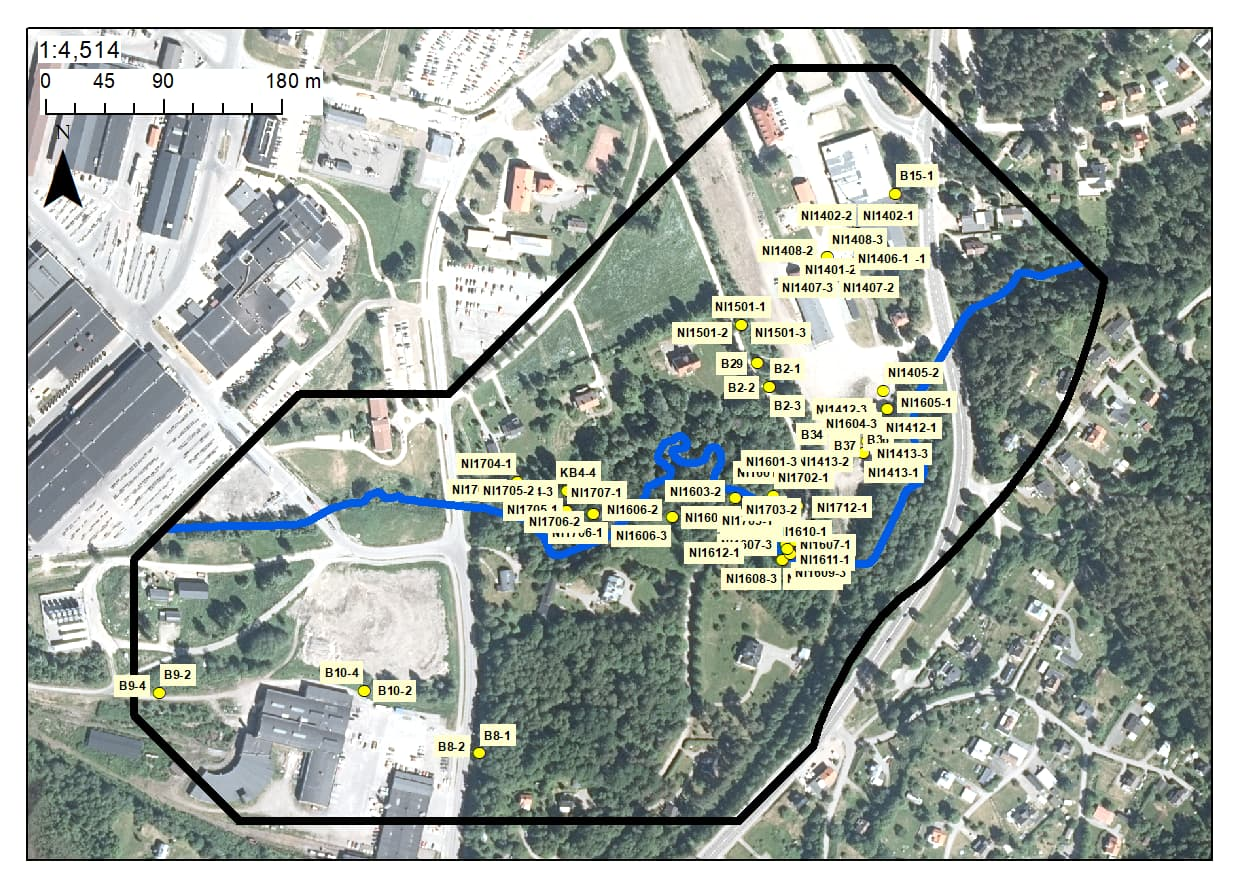

In [2]:
Image(filename="figures/hagfors-tracer-obs-monitoring-wells.jpg")

In [3]:
data_dir = os.path.join('..', '..', 'data', 'raw_data', 'tracer')
assert(data_dir)

In [4]:
os.listdir(data_dir)

['readme.md',
 'Tracerdata_2021-05-20.xlsx',
 'tracer_gacbor_filter.xlsx',
 '~$Tracerdata_2021-05-20.xlsx']

In [5]:
df = pd.read_excel(os.path.join(data_dir, 'tracer_gacbor_filter.xlsx'))
display(df)

,oul_no,station_no,station_name,datetime_placed,datetime_collected,fluorescein_conc_ppb,eosine_conc_ppb,rwt_conc_ppb,srb_conc_ppb,monitoring_round,exposure_time_days,comments
0,B7756,12,B15-1,2016-09-06 12:02:00,2016-09-09 14:10:00,NaN,NaN,NaN,NaN,BASELINE 1,3,NaN
1,B8798,12,B15-1,2016-09-09 14:10:00,2016-11-10 08:30:00,NaN,NaN,NaN,NaN,BASELINE 2,62,NaN
2,B9117,12,B15-1,2016-11-09 00:00:00,2016-12-06 09:30:00,NaN,NaN,NaN,NaN,ROUND 2,27,NaN
3,C0167,12,B15-1,2016-12-06 00:00:00,2017-01-24 08:20:00,NaN,NaN,NaN,NaN,ROUND 4,49,NaN
4,B7757,13,NI1401-2,2016-09-06 16:15:00,2016-09-09 13:20:00,NaN,NaN,NaN,NaN,BASELINE 1,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
343,D8779,139,B8-2,2018-11-07 00:00:00,2019-10-09 10:32:00,NaN,NaN,NaN,NaN,ROUND 32,336,NaN
344,D8782,141,B9-2,2018-11-07 00:00:00,2019-10-09 11:23:00,NaN,NaN,29.8,NaN,ROUND 32,336,NaN
345,D8783,143,B9-4,2018-11-07 00:00:00,2019-10-09 11:26:00,NaN,NaN,41.1,NaN,ROUND 32,336,NaN
346,D8785,146,B10-2,2018-11-07 00:00:00,2019-10-09 11:00:00,NaN,30.5,NaN,2.67,ROUND 32,336,NaN


Make sure datetime columns are of datetime data-type:

In [6]:
df['datetime_placed'] = pd.to_datetime(df['datetime_placed'])
df['datetime_collected'] = pd.to_datetime(df['datetime_collected'])

Sort values based on station name and date collected:

In [7]:
df = df.sort_values(['station_name', 'datetime_collected']).reset_index(drop=True)
display(df)

,oul_no,station_no,station_name,datetime_placed,datetime_collected,fluorescein_conc_ppb,eosine_conc_ppb,rwt_conc_ppb,srb_conc_ppb,monitoring_round,exposure_time_days,comments
0,D8785,146,B10-2,2018-11-07 00:00:00,2019-10-09 11:00:00,NaN,30.5,NaN,2.67,ROUND 32,336,NaN
1,D8786,148,B10-4,2018-11-07 00:00:00,2019-10-09 11:05:00,NaN,121.0,NaN,NaN,ROUND 32,336,NaN
2,B7756,12,B15-1,2016-09-06 12:02:00,2016-09-09 14:10:00,NaN,NaN,NaN,NaN,BASELINE 1,3,NaN
3,B8798,12,B15-1,2016-09-09 14:10:00,2016-11-10 08:30:00,NaN,NaN,NaN,NaN,BASELINE 2,62,NaN
4,B9117,12,B15-1,2016-11-09 00:00:00,2016-12-06 09:30:00,NaN,NaN,NaN,NaN,ROUND 2,27,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
343,D3413,124,NI1707-1,2018-08-28 00:00:00,2018-11-07 00:00:00,NaN,NaN,112.0,NaN,ROUND 25,71,NaN
344,D8772,124,NI1707-1,2018-11-07 00:00:00,2019-10-10 11:30:00,NaN,NaN,134.0,NaN,ROUND 32,337,NaN
345,C9188,113,NI1712-1,2017-08-04 00:00:00,2018-03-14 00:00:00,NaN,NaN,NaN,NaN,ROUND 18,222,NaN
346,D3405,113,NI1712-1,2018-03-14 00:00:00,2018-11-08 00:00:00,NaN,NaN,NaN,NaN,ROUND 25,239,NaN


It has been suggested to replace NaN's in the datasets with the non-detect limit (reporting limit) instead of zero. This is because when using PEST_HP or PEST++IES, the reporting limit values can be used as "lower than" observations.

Fill NaN with reporting limit values for each species:

In [8]:
tracer_limits = {
    'fluorescein_conc_ppb': 0.075,
    'eosine_conc_ppb': 0.150,
    'rwt_conc_ppb': 0.510,
    'srb_conc_ppb': 0.240,
}

In [9]:
for tracer, detection_limit in tracer_limits.items():
    df[tracer].fillna(detection_limit, inplace=True)
display(df)

,oul_no,station_no,station_name,datetime_placed,datetime_collected,fluorescein_conc_ppb,eosine_conc_ppb,rwt_conc_ppb,srb_conc_ppb,monitoring_round,exposure_time_days,comments
0,D8785,146,B10-2,2018-11-07 00:00:00,2019-10-09 11:00:00,0.075,30.50,0.51,2.67,ROUND 32,336,NaN
1,D8786,148,B10-4,2018-11-07 00:00:00,2019-10-09 11:05:00,0.075,121.00,0.51,0.24,ROUND 32,336,NaN
2,B7756,12,B15-1,2016-09-06 12:02:00,2016-09-09 14:10:00,0.075,0.15,0.51,0.24,BASELINE 1,3,NaN
3,B8798,12,B15-1,2016-09-09 14:10:00,2016-11-10 08:30:00,0.075,0.15,0.51,0.24,BASELINE 2,62,NaN
4,B9117,12,B15-1,2016-11-09 00:00:00,2016-12-06 09:30:00,0.075,0.15,0.51,0.24,ROUND 2,27,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
343,D3413,124,NI1707-1,2018-08-28 00:00:00,2018-11-07 00:00:00,0.075,0.15,112.00,0.24,ROUND 25,71,NaN
344,D8772,124,NI1707-1,2018-11-07 00:00:00,2019-10-10 11:30:00,0.075,0.15,134.00,0.24,ROUND 32,337,NaN
345,C9188,113,NI1712-1,2017-08-04 00:00:00,2018-03-14 00:00:00,0.075,0.15,0.51,0.24,ROUND 18,222,NaN
346,D3405,113,NI1712-1,2018-03-14 00:00:00,2018-11-08 00:00:00,0.075,0.15,0.51,0.24,ROUND 25,239,NaN


Note that all NaN's have now been replaced with the reporting limit for each tracer species.

Print name of monitoring wells containing GAC-samplers:

In [10]:
df.station_name.unique()

array(['B10-2', 'B10-4', 'B15-1', 'B2-1', 'B2-2', 'B2-3', 'B29', 'B34',
       'B35', 'B36', 'B37', 'B8-1', 'B8-2', 'B9-2', 'B9-4', 'KB1-2',
       'KB4-3', 'KB4-4', 'NI1401-1', 'NI1401-2', 'NI1402-1', 'NI1402-2',
       'NI1405-2', 'NI1406-1', 'NI1407-2', 'NI1407-3', 'NI1408-2',
       'NI1408-3', 'NI1412-1', 'NI1412-3', 'NI1413-1', 'NI1413-2',
       'NI1413-3', 'NI1501-1', 'NI1501-2', 'NI1501-3', 'NI1601-1',
       'NI1601-2', 'NI1601-3', 'NI1603-2', 'NI1604-3', 'NI1605-1',
       'NI1606-1', 'NI1606-2', 'NI1606-3', 'NI1607-1', 'NI1607-3',
       'NI1608-1', 'NI1608-3', 'NI1609-2', 'NI1609-3', 'NI1610-1',
       'NI1611-1', 'NI1612-1', 'NI1612-2', 'NI1701-1', 'NI1702-1',
       'NI1703-1', 'NI1703-2', 'NI1704-1', 'NI1704-2', 'NI1705-1',
       'NI1705-2', 'NI1706-1', 'NI1706-2', 'NI1707-1', 'NI1712-1'],
      dtype=object)

### Visualize the data

Because there are so many sites and not all of them have detected all (or any) of the tracers, let's create lists for each tracer containing only sites where concentrations are detected (just to prevent cluttered plots and make it easier to view the data):

In [11]:
fluorescein_detected = []
eosine_detected = []
rwt_detected = []
srb_detected = []

Append the name of the sites where a concentration is detected for each corresponding site and tracer element:

In [12]:
#Fluorescein
for site in df.station_name.unique():
    if any(i > tracer_limits['fluorescein_conc_ppb'] for i in df.loc[df['station_name'] == site]['fluorescein_conc_ppb']):
        fluorescein_detected.append(site)
print(fluorescein_detected)

['B35', 'B36', 'KB1-2', 'KB4-3', 'KB4-4', 'NI1405-2', 'NI1408-2', 'NI1408-3', 'NI1412-1', 'NI1501-1', 'NI1605-1', 'NI1705-1', 'NI1705-2', 'NI1706-1']


In [13]:
#Eosine
for site in df.station_name.unique():
    if any(i > tracer_limits['eosine_conc_ppb'] for i in df.loc[df['station_name'] == site]['eosine_conc_ppb']):
        eosine_detected.append(site)
print(eosine_detected)

['B10-2', 'B10-4', 'B36', 'KB1-2', 'NI1412-1', 'NI1607-1', 'NI1610-1', 'NI1611-1', 'NI1612-1', 'NI1612-2', 'NI1703-2']


In [14]:
#RWT
for site in df.station_name.unique():
    if any(i > tracer_limits['rwt_conc_ppb'] for i in df.loc[df['station_name'] == site]['rwt_conc_ppb']):
        rwt_detected.append(site)
print(rwt_detected)

['B9-2', 'B9-4', 'KB4-3', 'KB4-4', 'NI1406-1', 'NI1501-1', 'NI1501-2', 'NI1606-1', 'NI1704-1', 'NI1705-1', 'NI1705-2', 'NI1706-1', 'NI1706-2', 'NI1707-1']


In [15]:
#SRB
for site in df.station_name.unique():
    if any(i > tracer_limits['srb_conc_ppb'] for i in df.loc[df['station_name'] == site]['srb_conc_ppb']):
        srb_detected.append(site)
print(srb_detected)

['B10-2', 'B34', 'B37', 'KB1-2', 'NI1412-3', 'NI1413-3', 'NI1601-1', 'NI1601-2', 'NI1601-3', 'NI1603-2', 'NI1606-2', 'NI1607-1', 'NI1611-1', 'NI1612-1', 'NI1612-2', 'NI1701-1', 'NI1702-1', 'NI1703-2']


Function for plotting data:

In [16]:
def plot_tracerdata(sites_list, tracer_col):
    ncols = 3
    nrows = int(np.ceil(len(sites_list) / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12,16), sharex=True)

    for index, site in enumerate(sites_list):
        x = df.loc[df['station_name'] == site]['datetime_collected']
        y = df.loc[df['station_name'] == site][tracer_col]
        s = df.loc[df['station_name'] == site]['exposure_time_days']
        axes.flat[index].scatter(x, y, s=s, label=site)
        axes.flat[index].plot(x, y, label=site)
        axes.flat[index].title.set_text(site)

    for col in axes:
        for i in range(3):
            col[i].tick_params(axis='x', labelrotation=90)

    plt.tight_layout()

### Plotting

Marker size is determined by the number of days between `datetime_placed` and `datetime_collected`, i.e. colum `exposure_time_days` .

#### Plot Fluoresceine concentration:

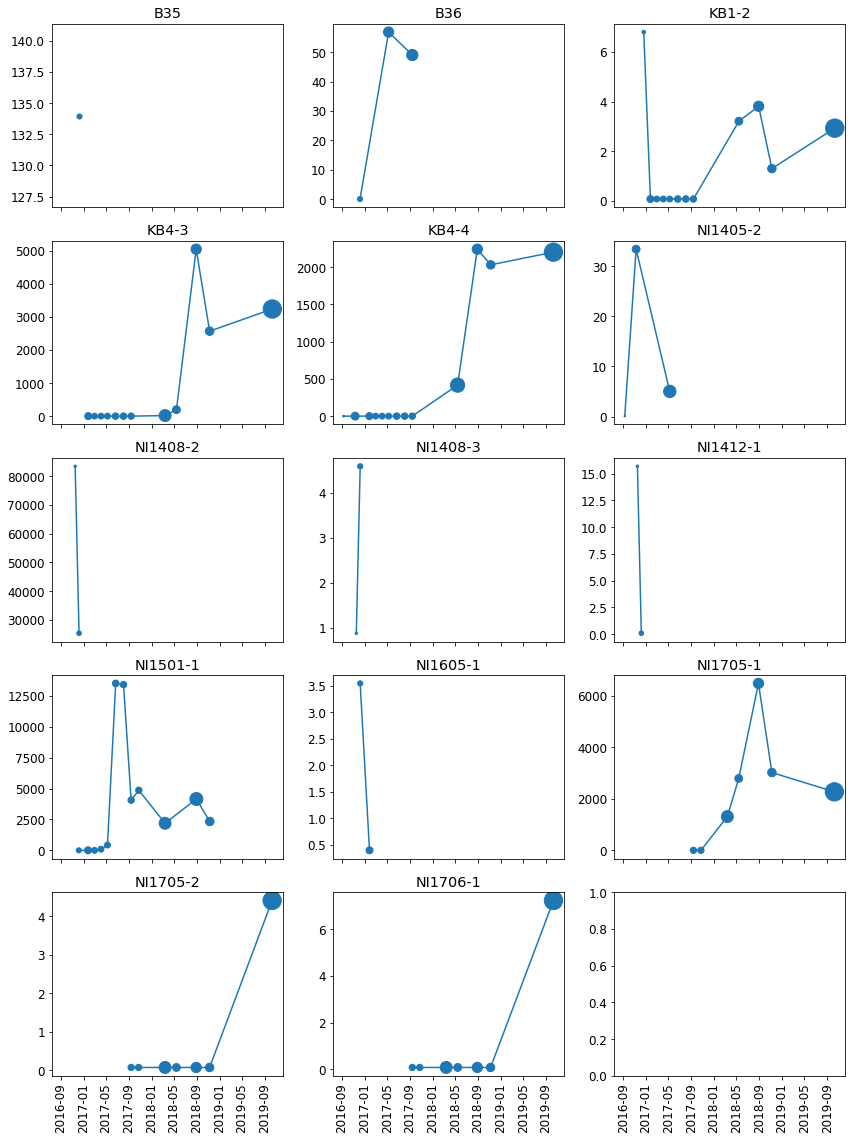

In [17]:
plot_tracerdata(fluorescein_detected, 'fluorescein_conc_ppb')

#### Plot Eosine concentrations:

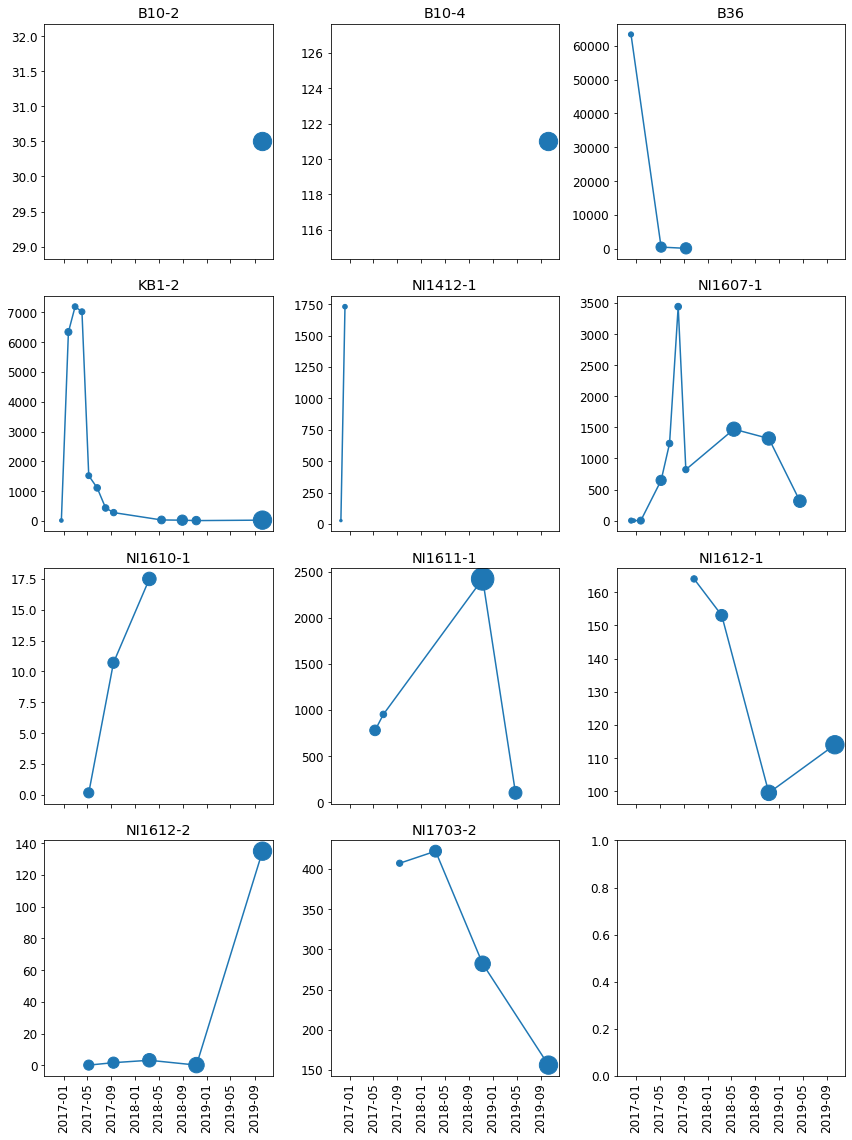

In [18]:
plot_tracerdata(eosine_detected, 'eosine_conc_ppb')

#### Plot Rhodamine WT concentrations:

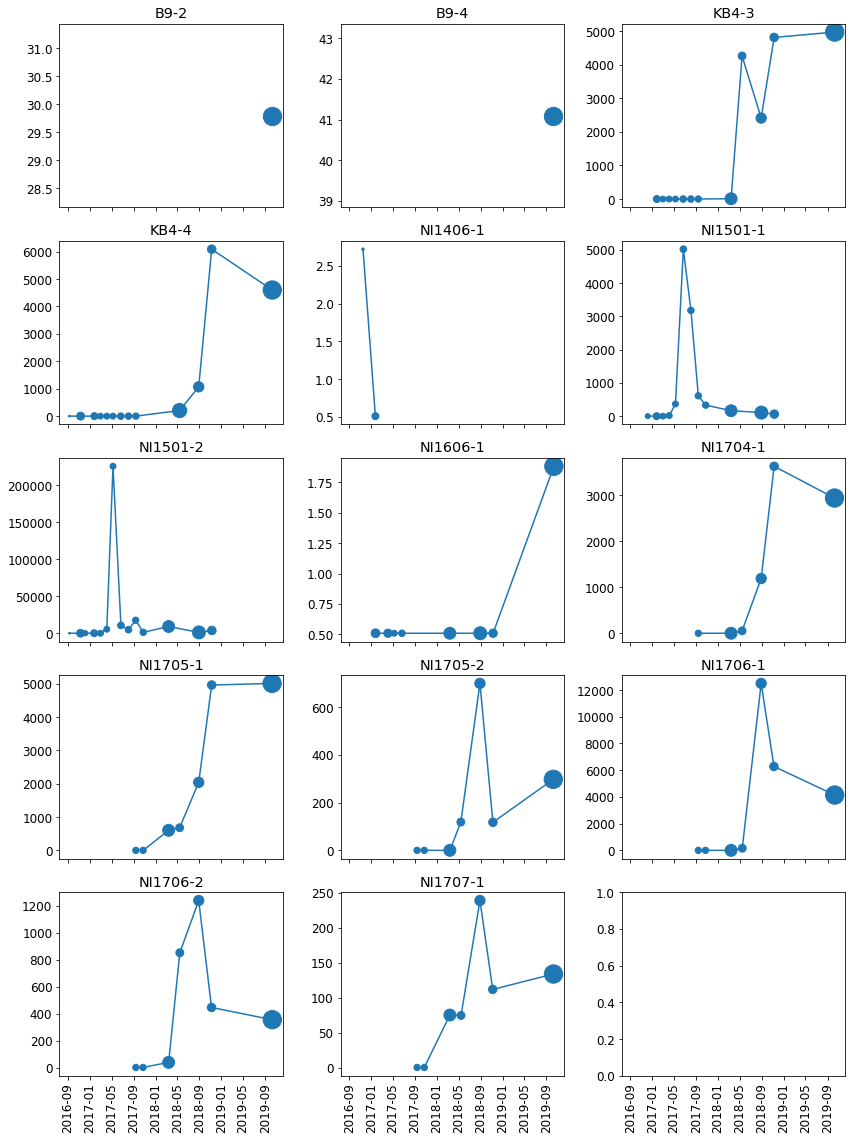

In [19]:
plot_tracerdata(rwt_detected, 'rwt_conc_ppb')

#### Plot Sulforhodamine B concentrations:

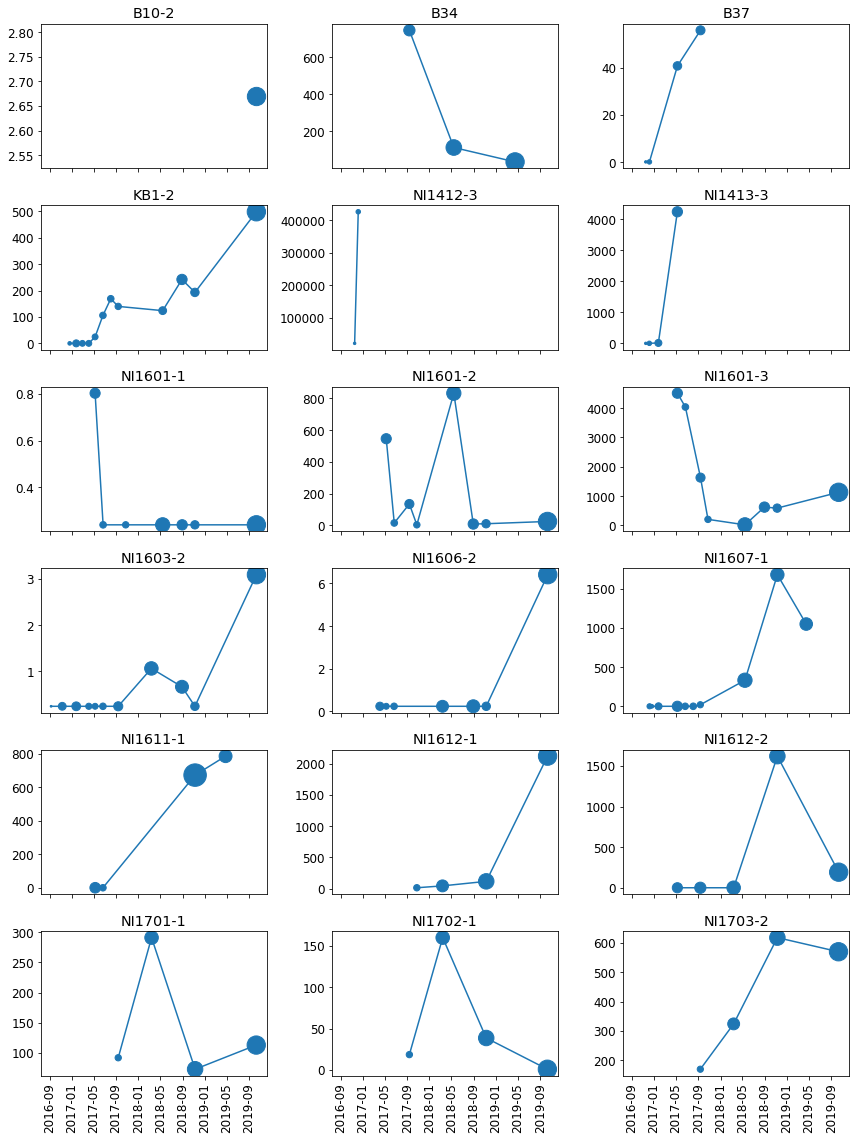

In [20]:
plot_tracerdata(srb_detected, 'srb_conc_ppb')

In [21]:
display(df)

,oul_no,station_no,station_name,datetime_placed,datetime_collected,fluorescein_conc_ppb,eosine_conc_ppb,rwt_conc_ppb,srb_conc_ppb,monitoring_round,exposure_time_days,comments
0,D8785,146,B10-2,2018-11-07 00:00:00,2019-10-09 11:00:00,0.075,30.50,0.51,2.67,ROUND 32,336,NaN
1,D8786,148,B10-4,2018-11-07 00:00:00,2019-10-09 11:05:00,0.075,121.00,0.51,0.24,ROUND 32,336,NaN
2,B7756,12,B15-1,2016-09-06 12:02:00,2016-09-09 14:10:00,0.075,0.15,0.51,0.24,BASELINE 1,3,NaN
3,B8798,12,B15-1,2016-09-09 14:10:00,2016-11-10 08:30:00,0.075,0.15,0.51,0.24,BASELINE 2,62,NaN
4,B9117,12,B15-1,2016-11-09 00:00:00,2016-12-06 09:30:00,0.075,0.15,0.51,0.24,ROUND 2,27,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
343,D3413,124,NI1707-1,2018-08-28 00:00:00,2018-11-07 00:00:00,0.075,0.15,112.00,0.24,ROUND 25,71,NaN
344,D8772,124,NI1707-1,2018-11-07 00:00:00,2019-10-10 11:30:00,0.075,0.15,134.00,0.24,ROUND 32,337,NaN
345,C9188,113,NI1712-1,2017-08-04 00:00:00,2018-03-14 00:00:00,0.075,0.15,0.51,0.24,ROUND 18,222,NaN
346,D3405,113,NI1712-1,2018-03-14 00:00:00,2018-11-08 00:00:00,0.075,0.15,0.51,0.24,ROUND 25,239,NaN


Rename `datetime_collected` to `datetime` (for some reason needed to prevent a bug in `pyemu.utils.smp_utils.dataframe_to_smp`).

In [22]:
df.rename(columns={'datetime_collected': 'datetime'}, inplace=True)

## Prepare datasets for OLPROC/OBSPROC

The concentration data to be used in OLPROC/OBSPROC should be *concentrations above detection limits at `datetime_collected`*. This concentration in turn, should be regarded as the sum of concentrations between `datetime_palced` and `datetime_collected` (for which we have to write a special function/program that intercepts the composite model between MODFLOW (GWT) output and OLPROC/OBSPROC).

However, OLPROC/OBSPROC should only be concerned with matching observed concentrations (i.e. above reporting limits, right? And treat values AT reporting limit as concentrations below that very limit) at `datetime_collected`.

Since there are four species, we must create four site sample files (ssf).

In [26]:
output_dir = os.path.join('..', '..', 'data', 'olproc_input')

Create ssf for Fluorescein:

In [34]:
pyemu.utils.smp_utils.dataframe_to_smp(
    df,
    os.path.join(output_dir, 'accumulated_fluorescein.ssf'),
    name_col='station_name',
    datetime_col='datetime',
    value_col='fluorescein_conc_ppb',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

Create ssf for Eosine:

In [35]:
pyemu.utils.smp_utils.dataframe_to_smp(
    df,
    os.path.join(output_dir, 'accumulated_eosine.ssf'),
    name_col='station_name',
    datetime_col='datetime',
    value_col='eosine_conc_ppb',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

Create ssf for Rhodamine WT:

In [36]:
pyemu.utils.smp_utils.dataframe_to_smp(
    df,
    os.path.join(output_dir, 'accumulated_rwt.ssf'),
    name_col='station_name',
    datetime_col='datetime',
    value_col='rwt_conc_ppb',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

Create ssf for Sulforhodamine B:

In [37]:
pyemu.utils.smp_utils.dataframe_to_smp(
    df,
    os.path.join(output_dir, 'accumulated_srb.ssf'),
    name_col='station_name',
    datetime_col='datetime',
    value_col='srb_conc_ppb',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

In [41]:
df.station_name.unique()

array(['B10-2', 'B10-4', 'B15-1', 'B2-1', 'B2-2', 'B2-3', 'B29', 'B34',
       'B35', 'B36', 'B37', 'B8-1', 'B8-2', 'B9-2', 'B9-4', 'KB1-2',
       'KB4-3', 'KB4-4', 'NI1401-1', 'NI1401-2', 'NI1402-1', 'NI1402-2',
       'NI1405-2', 'NI1406-1', 'NI1407-2', 'NI1407-3', 'NI1408-2',
       'NI1408-3', 'NI1412-1', 'NI1412-3', 'NI1413-1', 'NI1413-2',
       'NI1413-3', 'NI1501-1', 'NI1501-2', 'NI1501-3', 'NI1601-1',
       'NI1601-2', 'NI1601-3', 'NI1603-2', 'NI1604-3', 'NI1605-1',
       'NI1606-1', 'NI1606-2', 'NI1606-3', 'NI1607-1', 'NI1607-3',
       'NI1608-1', 'NI1608-3', 'NI1609-2', 'NI1609-3', 'NI1610-1',
       'NI1611-1', 'NI1612-1', 'NI1612-2', 'NI1701-1', 'NI1702-1',
       'NI1703-1', 'NI1703-2', 'NI1704-1', 'NI1704-2', 'NI1705-1',
       'NI1705-2', 'NI1706-1', 'NI1706-2', 'NI1707-1', 'NI1712-1'],
      dtype=object)